In [10]:
from sklearn import datasets 
%pylab inline
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import numpy as np
import heapq
import itertools

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
circles = datasets.make_circles(10000)

In [3]:
print (circles[0][:5])
print (circles[1][:5])

[[-0.93916621 -0.343463  ]
 [-0.61389951 -0.78938419]
 [ 0.79725009  0.0662744 ]
 [ 0.79627659  0.60493271]
 [ 0.27053324 -0.96271064]]
[0 0 1 0 0]


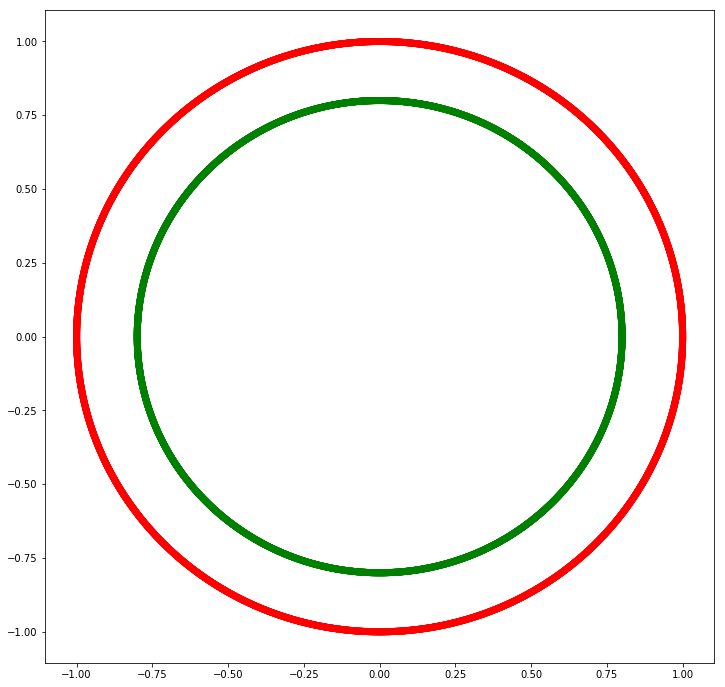

In [4]:
def plot_2d_dataset(data, colors):
    pyplot.figure(figsize(12,12))
    pyplot.scatter(map(lambda x: x[0], data[0]), map(lambda x: x[1], data[0]), c = data[1], cmap = colors)

colors = ListedColormap(["red", "green"])
plot_2d_dataset(circles, colors)


In [5]:
noise_circles = datasets.make_circles(10000, noise = 0.05)

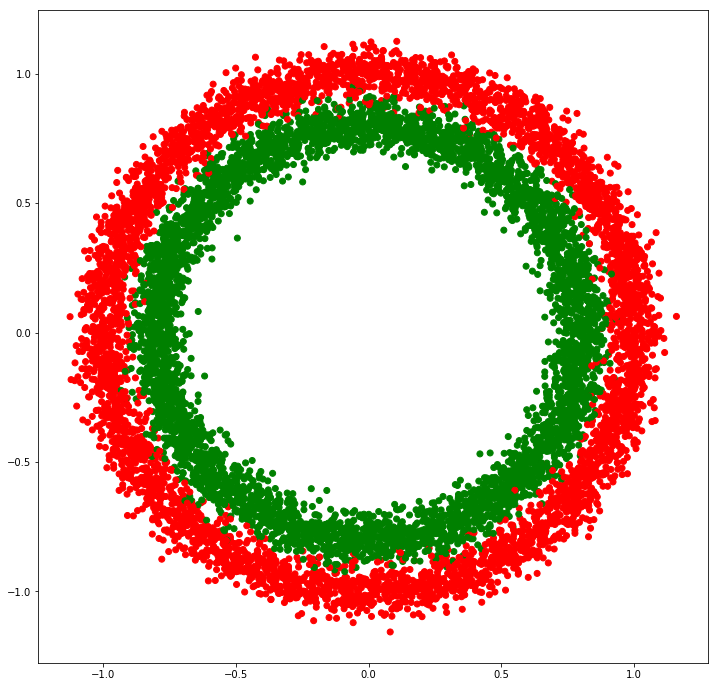

In [6]:
plot_2d_dataset(noise_circles, colors)

In [173]:
# K-D Tree realization
n = 2 # dimension

class Node:
    def __init__(self, point, left_child, right_child, tag):
        self.point = point
        self.left_child = left_child
        self.right_child = right_child
        self.tag = tag
        
class kd_tree:
    def search_knn(self, point, k):
        distance = lambda node: distance_sqr(node.point, point)
        knn = []
        self.search_node(self.root, point, k, knn, distance)
        return map(lambda items: items[1], knn)


    def search_node(self, node, point, k, knn, distance, depth=0):
        if node == None:
            return

        axis = depth % n
        dist_to_node = distance(node)
        
        # Add current node if it closer than at least one point in the queue
        # If the heap is full and size is k, we need to check if the
        # current node is closer than the current farthest node, and if it so, replace it.
        item = (-dist_to_node, node)
        if len(knn) >= k:
            if -dist_to_node > knn[0][0]:
                heapq.heapreplace(knn, item)
        else:
            heapq.heappush(knn, item)


        split_plane = node.point[axis]  # get the splitting plane
        # get the squared distance between the point and the splitting plane
        # (squared since all distances are squared).
        plane_dist = point[axis] - split_plane 
        plane_dist2 = plane_dist ** 2

        # Search the side of the splitting plane that the point is in
        if point[axis] < split_plane:
            if node.left_child != 0:
                self.search_node(node.left_child, point, k, knn, distance,  depth + 1)
        else:
            if node.right_child != 0:
                self.search_node(node.right_child, point, k, knn, distance,  depth + 1)

                
        # Search the other side of the splitting plane if it may contain
        # points closer than the farthest point in the current results.        
        if -plane_dist2 > knn[0][0] or len(knn) < k:
            if point[axis] < node.point[axis]:
                if node.right_child != 0:
                    self.search_node(node.right_child, point, k, knn, distance, depth + 1)
            else:
                if node.left_child != 0:
                    self.search_node(node.left_child, point, k, knn, distance, depth + 1)


    def __init__(self, root):
        self.root = root
        self.dimension = n
    
    
def distance_sqr(point1, point2):
    dist = 0
    for i in range(n):
        dist += (point1[i] - point2[i]) ** 2

    return dist

def _kd_tree(x, y):
    tagged_point_list = list(zip(x, y))
    return kd_tree(kd_node(tagged_point_list))

def kd_node(point_list, depth=0):
    try:
        k = len(point_list[0]) # assumes all points have the same dimension
    except IndexError as e: # if not point_list:
        return None
    # Select axis based on depth so that axis cycles through all valid values
    axis = depth % k
 
    # Sort point list and choose median as pivot element
    point_list.sort(key=lambda p: p[0][axis])
    median = int(len(point_list) / 2)
 
    # Create node and construct subtrees
    return Node(
        point_list[median][0],
        kd_node(point_list[:median], depth + 1),
        kd_node(point_list[median + 1:], depth + 1),
        point_list[median][1]
    )

noise_circles_list = list(noise_circles)
answers = noise_circles_list.pop()

noise_circles_points = np.asarray(noise_circles_list)

In [174]:
# Splitting into train and test
x_train, x_test, y_train, y_test = train_test_split(np.squeeze(noise_circles_points, axis=0), answers, test_size=0.3)

In [175]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model

k = 7  # number of neighbours
neighbors = KNeighborsClassifier(n_neighbors=k)
neighbors.fit(x_train, y_train) 

print("KNeighborsClassifier results:")
print round(accuracy_score(y_test, neighbors.predict(x_test)) * 100, 4)
print round(accuracy_score(y_train, neighbors.predict(x_train)) * 100, 4)

print("Example of predicting random point")
print(neighbors.predict([[0.79963404, -0.40925982]]))

clf = linear_model.SGDClassifier()
clf.fit(x_train, y_train)

print("SGD results:")
print round(accuracy_score(y_test, clf.predict(x_test)) * 100, 4)
print round(accuracy_score(y_train, clf.predict(x_train)) * 100, 4)

print("Example of predicting random point")
print(clf.predict([[0.79963404, -0.40925982]]))

KNeighborsClassifier results:
97.4333
98.0714
Example of predicting random point
[1]
SGD results:
45.4333
45.9
Example of predicting random point
[1]


In [179]:
class my_knn_classifier:
    def fit(self, x, y): 
        self.tree = _kd_tree(x, y) # creating our k-d tree
    
    def predict(self, x, k):
        k_nodes = self.tree.search_knn(x, k)  # find knn for the node
        class0, class1 = 0, 0
        for node in k_nodes:
            if node.tag == 1:
                class1 += 1
            else:
                class0 += 1
        if class1 > class0: # classify by the frequency of k neighbours
            return 1 
        else:
            return 0  


    def accuracy_score(self, X, Y, k):
        count = 0
        for x, y in zip(X, Y):
            answer = self.predict(x, k)
            if answer == y:
                count += 1
        return count

    
    def __init__(self):
        self.tree = 0
        self.classes = 2  # number of classes


my_knn = my_knn_classifier()
my_knn.fit(x_train, y_train)

print("My results:")
print("Predicted " + str(my_knn.accuracy_score(x_train, y_train, k)) + " from 7000")
print("Predicted " + str(my_knn.accuracy_score(x_test, y_test, k)) + " from 3000")

My results:
Predicted 6865 from 7000
Predicted 2923 from 3000
